# 随机梯度下降


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## 随机梯度更新

In [2]:
def f(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # 目标函数的梯度
    return 2 * x1, 4 * x2

In [3]:
'''
x1,x2：当前二维参数值
s1,s2：状态变量（本实现未使用，为保持接口统一）
f_grad：梯度计算函数，输入(x1,x2) 返回(g1,g2)
'''
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2) # 调用梯度函数，获得参数(x1,x2) 处的精确梯度值
    # 模拟有噪声的梯度
    '''
    模拟梯度噪声
    操作：在真实梯度上添加高斯噪声
    torch.normal(0.0,1,(1,))：从均值0、标准差1的正态分布采样一个随机数
    .item()：将张量转换为Python标量
    目的：模拟随机梯度下降中由小批量数据（minibatch） 导致的梯度估计误差
    '''
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    '''
    eta：基础学习率（外部定义，如eta=0.1）
    lr()：学习率调度函数（外部定义），返回随时间衰减的因子
    eta_t：当前时刻的实际学习率
    '''
    eta_t = eta * lr()
    '''
    更新公式：
    x_{1}←x_{1}−η_{t}⋅g_{1}
    ​x_{2}←x_{2}−η_{t}⋅g_{2}
    ​返回：新参数值+未改变的状态变量(0,0)
    '''
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: 0.330105, x2: 0.200155


e:\Anaconda3\envs\DL\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


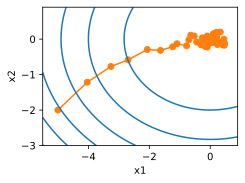

In [4]:
# 功能：始终返回固定的学习率乘数1;效果：学习率不衰减，全程保持恒定
def constant_lr():
    return 1
# 全局变量：SGD算法的基础步长设为0.1
eta = 0.1
'''
lr是一个函数对象（不是调用结果）
在SGD内部会执行eta_t=eta*lr()，此时lr()永远返回1
因此实际学习率恒为：η_{t}=0.1×1=0.1 
'''
lr = constant_lr  # 常数学习速度
'''
train_2d(sgd,steps=50,f_grad=f_grad)：用SGD优化器执行50轮迭代,返回优化轨迹[(x1₀,x2₀),(x1₁,x2₁),...,(x1₅₀,x2₅₀)]
show_trace_2d(f,...) ：绘制等高线图（蓝色）;叠加优化轨迹（橙色带圆点）
'''
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## 动态学习率
$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{多项式衰减}
\end{aligned}
$$


epoch 1000, x1: -0.779980, x2: -0.093856


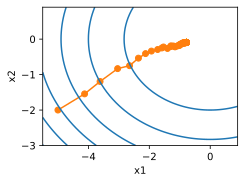

In [5]:
'''
功能：每调用一次，学习率衰减一次
global t：声明t是全局变量，在函数内部可修改外部定义的t
t+=1：每次调用时，全局变量t增加1
return math.exp(-0.1*t)：返回指数衰减值
数学形式：lr(t)=e^{−0.1t}
'''
def exponential_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)
# 起始值：t从1开始计数;关键：必须在函数定义后、训练前初始化，否则exponential_lr无法找到t
t = 1
# 注意：这里没有括号，是函数对象赋值，不是调用
# 作用：将lr变成一个可调用的调度器，在SGD内部通过lr()获取当前学习率
lr = exponential_lr
# 训练1000步：更长的训练时间利用学习率衰减
# 预期效果：初期：学习率接近0.9，快速下降;后期：学习率趋近于0，精细调整，避免震荡
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

$lr(t)=(1+0.1t)^{-0.5}=\frac{1}{\sqrt{1+0.1t} } $


epoch 50, x1: 0.189763, x2: 0.016495


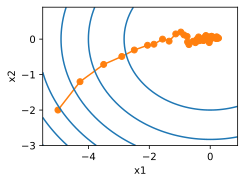

In [6]:
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr # 将多项式函数绑定为学习率调度器
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))